In [55]:
!pip install category_encoders
import pandas as pd

import numpy as np
import category_encoders as ce
import re
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [38]:
# Load the data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')


In [39]:
# Display the first few rows of the train dataset
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500
4,4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850


In [40]:
# Check for missing values
train_df.isna().sum()

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [41]:
test_df.isna().sum()

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64

In [42]:
# Extract numerical values from the engine column
def extract_engine_power(engine_str):
    match = re.search(r'(\d+(\.\d+)?)HP', engine_str)
    if match:
        return float(match.group(1))
    return 0

train_df['engine_power'] = train_df['engine'].apply(extract_engine_power)
test_df['engine_power'] = test_df['engine'].apply(extract_engine_power)


In [43]:
# Drop the original engine column
train_df.drop(columns=['engine'], inplace=True)
test_df.drop(columns=['engine'], inplace=True)

In [44]:
# Separate the target column from the training set
y = train_df['price']
X_train_full = train_df.drop(columns=['price'])

In [45]:
# Encoding categorical variables using category_encoders
categorical_features = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

In [46]:
# Fit the encoder on training data and transform both train and test data
encoder = ce.OneHotEncoder(cols=categorical_features, handle_unknown='ignore', use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_full)
X_test_encoded = encoder.transform(test_df)

In [47]:
# Ensure the test set has the same columns as the train set
train_columns = set(X_train_encoded.columns)
test_columns = set(X_test_encoded.columns)

missing_train_cols = test_columns - train_columns
missing_test_cols = train_columns - test_columns

for col in missing_train_cols:
    X_train_encoded[col] = 0
for col in missing_test_cols:
    X_test_encoded[col] = 0


In [48]:
# Reorder columns to match
X_test_encoded = X_test_encoded[X_train_encoded.columns]

In [49]:
# Standardize numerical features
numerical_features = ['model_year', 'milage', 'engine_power']
scaler = StandardScaler()
X_train_encoded[numerical_features] = scaler.fit_transform(X_train_encoded[numerical_features])
X_test_encoded[numerical_features] = scaler.transform(X_test_encoded[numerical_features])

In [50]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)

In [53]:
# Build the model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [54]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
1357/1357 [==============================] - 9s 6ms/step - loss: 6321391104.0000 - mse: 6321391104.0000 - val_loss: 3320679424.0000 - val_mse: 3320679424.0000
Epoch 2/50
1357/1357 [==============================] - 13s 9ms/step - loss: 6282125312.0000 - mse: 6282125312.0000 - val_loss: 3331538176.0000 - val_mse: 3331538176.0000
Epoch 3/50
1357/1357 [==============================] - 13s 10ms/step - loss: 6276753408.0000 - mse: 6276753408.0000 - val_loss: 3319968000.0000 - val_mse: 3319968000.0000
Epoch 4/50
1357/1357 [==============================] - 18s 13ms/step - loss: 6276285440.0000 - mse: 6276285440.0000 - val_loss: 3307816704.0000 - val_mse: 3307816704.0000
Epoch 5/50
1357/1357 [==============================] - 9s 7ms/step - loss: 6271838208.0000 - mse: 6271838208.0000 - val_loss: 3311086336.0000 - val_mse: 3311086336.0000
Epoch 6/50
1357/1357 [==============================] - 8s 6ms/step - loss: 6266170880.0000 - mse: 6266170880.0000 - val_loss: 3288344320.0000 - 

In [56]:
# Evaluate on validation set
val_predictions = model.predict(X_val)
mse = mean_squared_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

340/340 [==============================] - 1s 2ms/step
MSE: 2472818351.575544
R2 Score: 0.15847613688845819


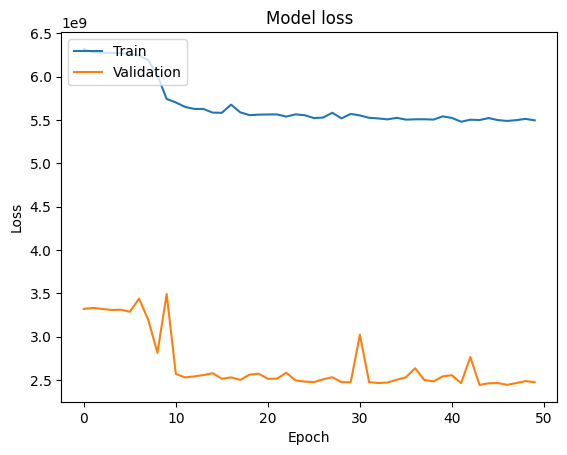

In [57]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [58]:
# Make predictions on the test set
test_predictions = model.predict(X_test_encoded)

1131/1131 [==============================] - 3s 3ms/step


In [59]:
# Create a DataFrame for the results
submission_df = pd.DataFrame({'id': test_df['id'], 'price': test_predictions.flatten()})

In [60]:
# Save predictions to a CSV file in the required format
submission_df.to_csv('Test_Predictions_2_Keras.csv', index=False)